In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
from source.kinetic_mechanisms import JaxKineticMechanisms as jm
from source.building_models import JaxKineticModelBuild as jkm
from source.load_sbml.sbml_load import *
from source.load_sbml.sbml_model import SBMLModel
import jax.numpy as jnp
import jax
import numpy as np
from source.utils import get_logger
logger = get_logger(__name__)
import diffrax 
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import sys


/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [2]:
# a simple sbml model
filepath = (
      "models/sbml_models/working_models/Smallbone2011_TrehaloseBiosynthesis.xml")

model = SBMLModel(filepath)
S=model._get_stoichiometric_matrix()
JaxKmodel = model.get_kinetic_model()
JaxKmodel = jax.jit(JaxKmodel)

ts = jnp.linspace(0,20,2000)
# #parameters are not yet defined
global_params = get_global_parameters(model.model)
params = {**model.local_params, **global_params}

ys=JaxKmodel(ts,model.y0,params)

16:05:51,986 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
16:05:51,986 - source.load_sbml.sbml_model - INFO - Model loaded.
16:05:51,987 - source.load_sbml.sbml_model - INFO -  number of species: 16
16:05:51,987 - source.load_sbml.sbml_model - INFO -  number of reactions: 8
16:05:51,987 - source.load_sbml.sbml_model - INFO -  number of global parameters: 13
16:05:51,987 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 10
16:05:51,987 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 0
16:05:51,988 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 6
16:05:51,988 - source.load_sbml.sbml_model - INFO -  number of event rules: 0
16:05:52,013 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
16:05:52,013 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
16:05:52,015 - jax._src.xla_b

In [3]:
# ys=JaxKmodel(ts,model.y0,params)



# global_params, local_params = separate_params(params)
# global_params = construct_param_point_dictionary(JaxKmodel.v_symbol_dictionaries,
#                                                          JaxKmodel.reaction_names,
#                                                          global_params) 
# args=(global_params, local_params,JaxKmodel.time_dict)
# a=[]
# for i in range(2000):
#     flux=JaxKmodel.func(0,ys[i,:],args)
#     flux=flux[0]
#     a.append(flux)

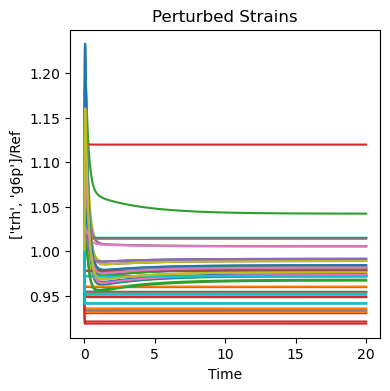

In [101]:
class DesignBuildTestLearnCycle:
    """A class that represents a metabolic engineering process. The underlying process is a kinetic model (parameterized and with initial conditions). Can be used
    to simulate scenarios that might occur in true optimization processes
    Input:
    1.  A model: either build or SBML
    2. Parameters: defined in a global way. This will represent the state of optimization process 
    3. Initial conditions for the model
    4. Time evaluation scale of the process. 
    
    
    """
    def __init__(self,
                 model,
                 parameters:dict,
                 initial_conditions :jnp.array,
                 timespan:jnp.array,
                 target:list):
        self.species_names=model.species_names
        self.kinetic_model=jax.jit(model.get_kinetic_model())
        self.parameters=parameters
        self.initial_conditions=initial_conditions
        self.timespan=timespan
        self.cycle_status=0
        self.library_units=None #library defines the building blocks of actions when constructing ME scenarios
        self.designs_per_cycle={}
        self.reference_production_value=None
        self.target=target
    


    def DESIGN_establish_library_elements(self, parameter_target_names, parameter_perturbation_values):
        """
        The actions that can be taken when sampling scenarios during the Design-phase.
        From an experimental perspective, this can be viewed as the library design phase.
        
        Input:
        - parameter_target_names: names of the parameters that we wish to perturb
        - parameter_perturbation_values: the actual perturbation (promoter) values of the parameters.
        These are defined RELATIVE to the reference state.
        """
        # Check that all parameter_target_names are valid
        for pt in parameter_target_names:
            if pt not in self.parameters.keys():
                logger.error(f"Parameter target {pt} not in the model. Perhaps a spelling mistake?")
                return None  # Return None and do not overwrite self.library_units

        # If all parameters are valid, flatten the combinations
        flattened_combinations = [
            (name, value)
            for name, values in zip(parameter_target_names, parameter_perturbation_values)
            for value in values
        ]
        
        # Create a DataFrame for the elementary actions
        elementary_actions = pd.DataFrame(flattened_combinations, columns=['parameter_name', 'promoter_value'])

        self.library_units = elementary_actions
        self.parameter_target_names=parameter_target_names
        return elementary_actions
    
    def DESIGN_assign_probabilities(self,occurence_list=None):
        """This functions assigns a probability to each element in the action list. Can be viewed as changing concentrations in a library design"""
        rows,cols=np.shape(self.library_units)
        if occurence_list is not None:
            if len(occurence_list)==rows:
                self.library_units['probability']=np.array(occurence_list)/np.sum(occurence_list)
                return_message="manual probabilities"
                pass 
            else:
                return_message="None"
                logger.error(f"Length of list of occurences of promoters is not matching ")
        else:
            return_message="equal probabilities"
            self.library_units['probability']=np.ones(rows)/rows
        return return_message
    
    def DESIGN_generate_strains(self,elements,samples,replacement=False):
        """Sample designs given the elementary actions given
        Input: number of elements to choose from the library (typically 6), number of samples.
        Replacement means whether we allow duplicate genes in the designs."""
        strains=[]
        strain_promoters=[]
        for i in range(samples):
            perturbed_parameters=dbtl_cycle.parameters.copy()
            sample=dbtl_cycle.library_units.sample(n=elements,weights=dbtl_cycle.library_units['probability'],replace=replacement)[['parameter_name','promoter_value']]
            strain={}

            for param, value in zip(sample['parameter_name'].values, sample['promoter_value']):
                if param in strain:
                    strain[param] += value  # Sum the values if the key exists
                else:
                    strain[param] = value   # Add the new key-value pair if it doesn't exist

            #overwrite reference parameters.
            strain_promoter={}
            for key,values in strain.items():
                perturbed_parameters[key]=perturbed_parameters[key]*strain[key]
                strain_promoter[key]=strain[key]

            strains.append(perturbed_parameters)
            strain_promoters.append(strain_promoter)


        self.designs_per_cycle[f"cycle_{self.cycle_status}_designs"]=strain_promoters
        return strains

    def BUILD_simulate_strains(self, strains_perturbed, plot=False):
        """Simulates perturbations with respect to the reference strain. Takes the mean value of the last 10 simulated steps. We then save this into the designs_per_cycle status  """
        
        # Simulate the reference strain
        ys_ref = self.kinetic_model(ts, self.initial_conditions, self.parameters)
        ys_ref = pd.DataFrame(ys_ref, columns=self.species_names)
        ys_ref = ys_ref[self.target]

        ys_ref_value=np.mean(ys_ref.iloc[-10:],axis=0)

        if plot:
            fig, ax = plt.subplots(figsize=(4, 4))

        
        # Loop through the perturbed strains and simulate each one
        simulated_values={str(i):[] for i in self.target}
        for strain_p in strains_perturbed:
            ys = self.kinetic_model(ts, self.initial_conditions, strain_p)
            ys = pd.DataFrame(ys, columns=self.species_names)
            ys = ys[self.target]
            ys=ys/ys_ref

            ys_final=np.mean(ys.iloc[-10:],axis=0)
            
            for targ in self.target:
                simulated_values[targ].append(ys_final[targ])



            if plot:
                ax.plot(ts, ys, label=f'Strain {strain_p}')  # Add a label for each strain if desired
        if plot:
            ax.set_title('Perturbed Strains')
            ax.set_xlabel('Time')
            ax.set_ylabel(f"{self.target}/Ref")
            plt.show()
        
        self.reference_production_value=ys_ref_value
        return simulated_values
    
        ### We now have simulated values that are strains. We want to have synthetic data that can be used to learn features in the data of importance

        ### we need to have a few functions:
        # a function that formats the generated dataset given the reference parameter set as well as values (TEST)
        # a function that can add noise to the measurements (TEST add noise)

    def TEST_add_noise(self,values,percentage,type="homoschedastic"):
        """add noise to the training set, to see the effect of noise models on performance. Includes homoschedastic or heteroschedastic noise for a certain percentage.
        Other experiment specific noise models could be added as well. One then needs to model the noise w.r.t to its screening value"""

        noised_values={}
        if type=="homoschedastic":            
            #look back whether this is actually the right way to do it
            for targ in self.target:

                values_new=np.random.normal(values[targ],percentage)
                values_new[values_new<0]=0

                noised_values[targ]=values_new

        if type=="heteroschedastic":
            #We assume that the noise level is given by X_m=D*X_true +X_true, where D is the percentage of deviation. We now model this as a simple gaussian, dependent on percentage*Xtrue
            for targ in self.target:

                values_new=np.random.normal(values[targ],percentage*np.array(values[targ]))
                values_new[values_new<0]=0
                noised_values[targ]=values_new

        return noised_values


    def TEST_format_dataset(self,strain_designs,production_values,reference_parameters):
        """Function that given strain designs and a reference strain (parameter set) formats the datasets as a pandas df for further use in ML/BO or whatever,
        the index will be coded with a cycle status coding. The last column is the.
        """

        strain_names=[f"cycle{self.cycle_status}_strain{i}" for i in range(len(strain_designs))]

        train_X=pd.DataFrame(strain_designs,index=strain_names)/reference_parameters
        train_X=train_X[self.parameter_target_names]
        
        for targ in self.target:
            train_X[f"Y_{targ}"]=production_values[targ]#/self.reference_production_value[targ]

        # print(train_x[self.target)
        return train_X
    
    ### Now the learning  and recommendation phase
    ### We would like an elegant way to include ML methods from outside the function (e.g., sklearn, xgboost)
    ### Or should we actually make an additional structure on top of Design-Build-Test-Learn-Cycle? The sort of Automated Lab structure
        
        



            
## one experimental cycle
dbtl_cycle=DesignBuildTestLearnCycle(model=model,
                          parameters=params,
                          initial_conditions=model.y0,
                          timespan=ts,
                          target=['trh','g6p'])
parameter_target_names=['lp.pgi.Kf6p','lp.hxk.Vmax','lp.tpp.Vmax','lp.hxk.Kg6p']
parameter_perturbation_value=[[0.5,1,1.5,2],[1.2,1.5,1.8],[1.1,1.6,1.3],[1.1,2,3]]
dbtl_cycle.DESIGN_establish_library_elements(parameter_target_names,
                                               parameter_perturbation_value)
dbtl_cycle.DESIGN_assign_probabilities([1,1,1,1,1,1,1,1,1,1,1,1,1])
strain_designs=dbtl_cycle.DESIGN_generate_strains(elements=6,samples=30,replacement=False)
values=dbtl_cycle.BUILD_simulate_strains(strain_designs,plot=True)
noised_values=dbtl_cycle.TEST_add_noise(values,0.1,type='heteroschedastic')
data=dbtl_cycle.TEST_format_dataset(strain_designs=strain_designs,
                               production_values=noised_values,
                               reference_parameters=dbtl_cycle.parameters)







In [97]:
data

,lp.pgi.Kf6p,lp.hxk.Vmax,lp.tpp.Vmax,lp.hxk.Kg6p,Y_trh,Y_g6p
cycle0_strain0,2.5,1.0,2.4,5.0,0.828160,1.015562
cycle0_strain1,3.5,1.8,2.9,1.0,0.951716,0.909970
cycle0_strain2,2.0,3.3,2.7,3.0,1.081324,1.000403
cycle0_strain3,3.0,1.5,1.1,2.0,0.905236,1.002698
cycle0_strain4,2.0,1.2,1.1,3.1,0.933892,0.897790
cycle0_strain5,3.5,1.2,1.3,1.1,0.890667,0.935684
cycle0_strain6,3.0,1.8,2.4,3.0,1.095557,0.911004
cycle0_strain7,1.0,3.3,2.9,3.0,1.101100,1.173829
cycle0_strain8,3.0,2.7,1.0,4.1,0.920366,0.959484
cycle0_strain9,3.0,1.5,2.4,2.0,0.841636,0.940920


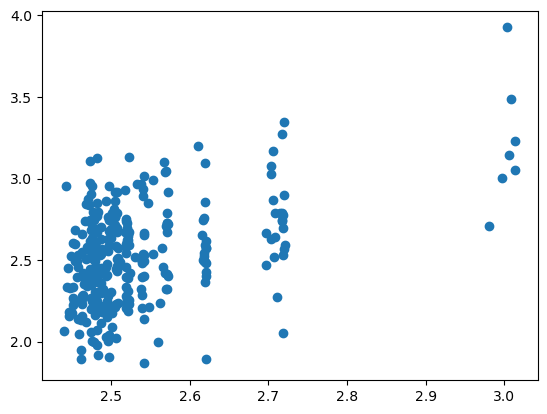

In [44]:
# plt.hist(np.random.normal(1.5,scale=0.1,size=1000))
# plt.hist(np.random.normal(1,scale=0.1,size=1000))


plt.scatter(values['g6p'],np.random.normal(values['g6p'],np.array(values['g6p'])*0.1))

(array([  6.,  12.,  42., 111., 235., 274., 187., 105.,  22.,   6.]),
 array([1.94165934, 2.14078928, 2.33991921, 2.53904914, 2.73817907,
        2.937309  , 3.13643893, 3.33556886, 3.53469879, 3.73382872,
        3.93295866]),
 <BarContainer object of 10 artists>)

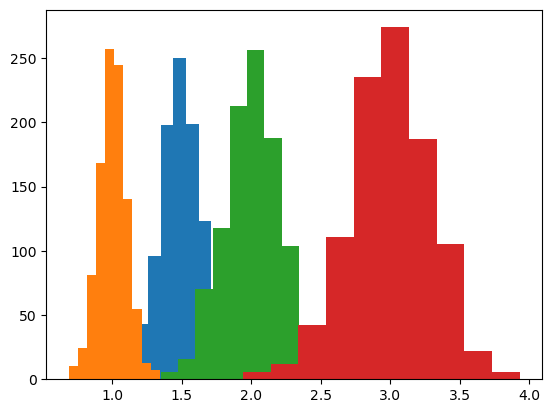

In [31]:
plt.hist(np.random.normal(1.5,scale=1.5*0.1,size=1000))

plt.hist(np.random.normal(1,scale=1*0.1,size=1000))
plt.hist(np.random.normal(2,scale=2*0.1,size=1000))
plt.hist(np.random.normal(3,scale=3*0.1,size=1000))

(array([294., 271., 144., 117.,  31.,  65.,   0.,   0.,   0.,  78.]),
 array([0.966879  , 0.97459907, 0.98231914, 0.99003921, 0.99775928,
        1.00547935, 1.01319941, 1.02091948, 1.02863955, 1.03635962,
        1.04407969]),
 <BarContainer object of 10 artists>)

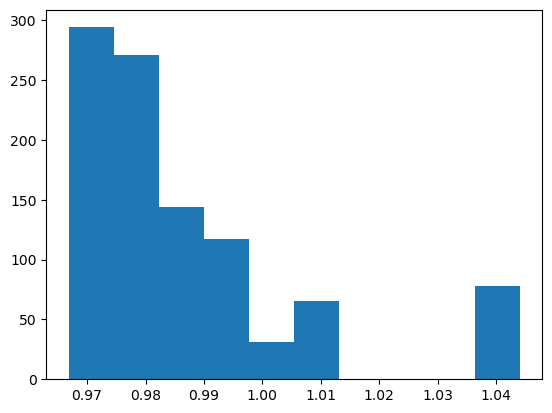

In [145]:
# the library will look like  
# Gene A p1
# Gene A p2
parameter_target_names=['lp.pgi.Kf6p','lp.hxk.Vmax','lp.tpp.Vmax']
parameter_perturbation_value=[[0.5,1,1.5],[1.2,1.5,1.8],[2,4,6]]
parameter_perturbation_occurence=[[1,1,1],[1,1,1],[1,1,1]]
# pd.DataFrame((itertools.product(parameter_target_names,parameter_promoter_values)))

# Use itertools.product to create the combinations
combinations = itertools.product(parameter_target_names, *parameter_perturbation_value)

flattened_combinations = [
    (name, value, occurrence)
    for name, values, occurrences in zip(parameter_target_names, parameter_perturbation_value, parameter_perturbation_occurence)
    for value, occurrence in zip(values, occurrences)
]

elementary_actions = pd.DataFrame(flattened_combinations, columns=['parameter_target', 'parameter_perturbation','occurence'])
elementary_actions['occurence']=elementary_actions['occurence']/elementary_actions['occurence'].sum()




array(['lp.tpp.Vmax', 'lp.pgi.Kf6p', 'lp.hxk.Vmax', 'lp.tpp.Vmax',
       'lp.pgi.Kf6p', 'lp.hxk.Vmax'], dtype=object)

In [ ]:
def equal_sampling_scenario(enz_names, perturb_range, N):
    """
    This function generates a list of designs for a scenario where each enzyme in a set of enzymes 
    has an equal chance of being perturbed within a certain range.
    
    :param enz_names: a list of strings representing enzyme names
    :param perturb_range: a list of tuples representing the perturbation range for each enzyme. 
    Each tuple contains two floats representing the minimum and maximum perturbation values.
    :param N: an integer representing the number of designs to generate
    
    :return: a list of dictionaries where each dictionary represents a design. Each dictionary has keys 
    that correspond to enzyme names and values that correspond to the perturbation value for that enzyme. 
    Additionally, the function returns a list of lists where each inner list represents a design and contains
    perturbation values for each enzyme.
    """
    library_choices=dict(zip(enz_names,perturb_range))# create a dictionary that maps each enzyme to its perturbation range
    cart=[] # create an empty list to hold the perturbation values for each design
    designs_list=[]
    for i in range(N):# loop N times to generate N designs
        design=[]
        for j in enz_names:
        
            x=np.random.choice(library_choices[j])# randomly select a perturbation value for the enzyme
            design.append(x)
        cart.append(design)
    for i in range(len(cart)):
        design=dict(zip(enz_names,cart[i]))# create a dictionary that maps enzyme names to perturbation values for the design
        designs_list.append(design)
    return designs_list,cart  # return the list of design dictionaries and the list of design perturbation values